Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3785625].
Clipping inp

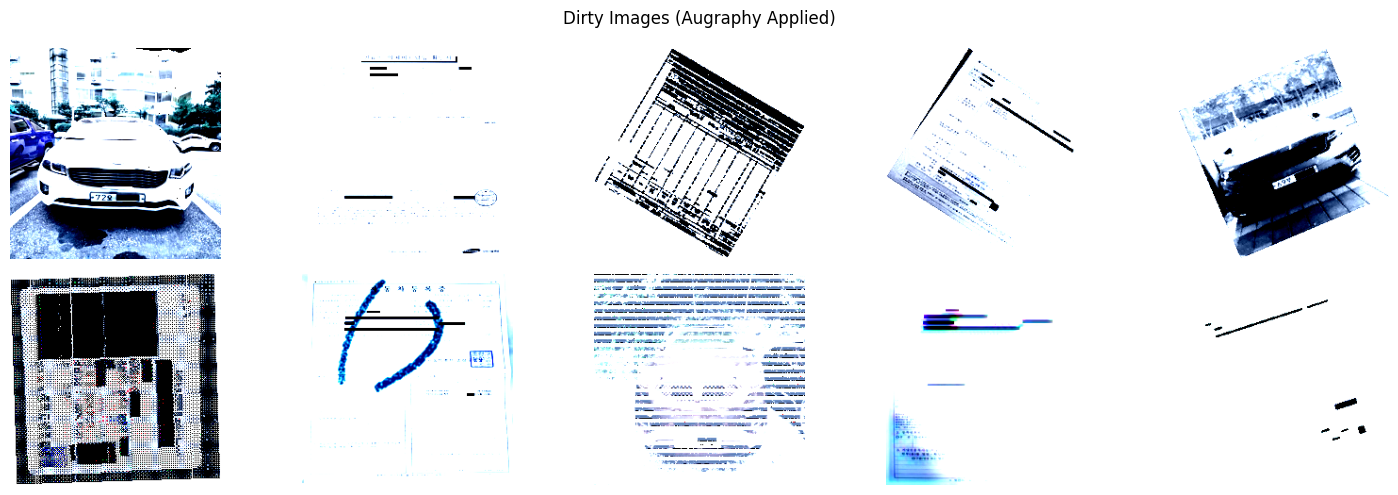

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.4722441].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5071026].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6465361].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7457983].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6813945]

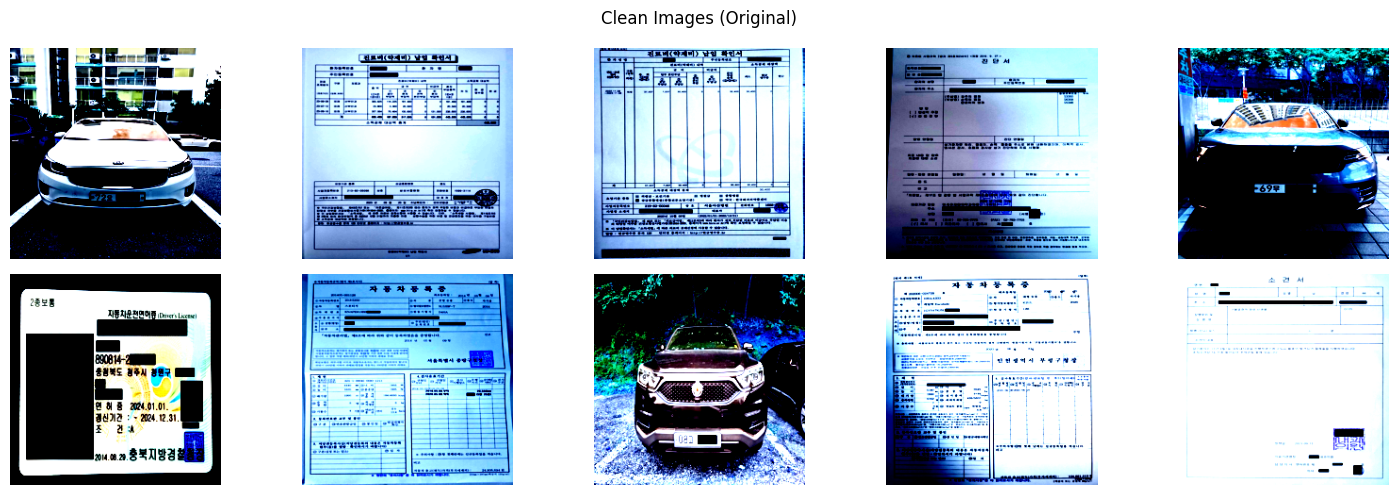

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np

from torch.utils.data import DataLoader
from torchvision import datasets

from torchvision import transforms
from augraphy import *

from torch.utils.data import Dataset
import glob
from PIL import Image

from dotenv import load_dotenv, dotenv_values
# 환경변수 읽기
if (python_path := dotenv_values().get('PYTHONPATH')) and python_path not in sys.path: sys.path.append(python_path)

from src.data.FullAugraphyPipeline import FullAugraphyPipeline
from src.data.ImageDataset import ImageDataset
from src.util import config

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = glob.glob(f"{root_dir}/**/*.jpg", recursive=True)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0  # 더미 레이블


augmentation_pipeline = FullAugraphyPipeline(max_effects=3)

# 커스텀 변환 클래스 정의
class To_BGR(object):
    """PIL RGB 이미지를 numpy BGR 이미지로 변환"""
    def __call__(self, image):
        image_numpy = np.array(image)
        if len(image_numpy.shape) < 3:
            return cv2.cvtColor(image_numpy, cv2.COLOR_GRAY2BGR)
        else:
            return cv2.cvtColor(image_numpy, cv2.COLOR_RGB2BGR)

# 수정된 변환 파이프라인
dirty_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    To_BGR(),
    augmentation_pipeline,  # Augraphy 적용
    transforms.ToTensor(),  # numpy -> tensor
     # 정규화
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

clean_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
     # 정규화
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dirty_dataset = ImageDataset(config.CV_CLS_TRAIN_CSV, config.CV_CLS_TRAIN_DIR, transform=dirty_transforms)
clean_dataset = ImageDataset(config.CV_CLS_TRAIN_CSV, config.CV_CLS_TRAIN_DIR, transform=clean_transforms)

""" # 데이터셋 생성 (dirty 이미지용)
dirty_dataset = CustomImageDataset(
    root_dir='/data/ephemeral/home/python_work/git/upstageailab-cv-classification-cv_3/notebooks/duhwan/data/row/train',
    transform=dirty_transforms
)

# 데이터셋 생성 (clean 이미지용)
clean_dataset = CustomImageDataset(
    root_dir='/data/ephemeral/home/python_work/git/upstageailab-cv-classification-cv_3/notebooks/duhwan/data/row/train',
    transform=clean_transforms
) """

# 데이터 로더 생성
dirty_loader = DataLoader(dirty_dataset, batch_size=32, shuffle=False)
clean_loader = DataLoader(clean_dataset, batch_size=32, shuffle=False)


def show_images_from_loader(loader, title, num_images=10):
    """데이터 로더에서 이미지를 가져와서 시각화하는 함수"""
    images_shown = 0
    cols = num_images // 2
    plt.figure(figsize=(15, 5))
    
    for images, _ in loader:
        for i in range(images.size(0)):
            if images_shown >= num_images:
                break
            
            # 텐서를 numpy 배열로 변환 (CHW -> HWC)
            img = images[i].permute(1, 2, 0).numpy()
            
            # 서브플롯 생성
            plt.subplot(2, cols, images_shown + 1)
            plt.imshow(img)
            plt.axis('off')
            images_shown += 1
            
        if images_shown >= num_images:
            break
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# 사용 예시
# Dirty 이미지 10개 시각화
show_images_from_loader(dirty_loader, 'Dirty Images (Augraphy Applied)', num_images=10)

# Clean 이미지 10개 시각화  
show_images_from_loader(clean_loader, 'Clean Images (Original)', num_images=10)